Reference：
[House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)


1. Ames housing dataset：
  https://www.mariopasquato.com/fun-with-data/ames-housing-dataset/
  -> 利用 salePrice (median) 和幾個變數之間的關係

2. Comprehensive data exploration with Python
  https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python

3. Predicting house price with linear regression
  https://www.kaggle.com/code/juanconher/predicting-house-price-with-linear-regression

4. A study on Regression applied to the Ames dataset
  https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook

4. House Prices Prediction using TFDF (Decision Forests)
  https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf

# **1. 讀入封包 Import Some Packages**

In [ ]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For data preprocess
import numpy as np
import pandas as pd
import os
import csv
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler  ## MinMaxScaler for normalize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm


# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Feature selection
from sklearn.model_selection import KFold
#Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler # SelectKBest 挑選出K個分數最高的特徵
from sklearn.feature_selection import SelectKBest # 這是一稱為aNOVA的統計檢驗方法
from sklearn.feature_selection import f_classif



# modules from sklearn used in regression analysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error

# module for Q-Q plot
from scipy import stats

# ignore warnings from seaborn and sklearn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.options.display.max_rows = 100

# **Some Utilities**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# **Import** **Files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#train = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv',index_col='Id')
train = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv',index_col='Id')
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# **EDA (Exploratory Data Analysis) 探索式資料分析**

1. 瞭解資料，獲取資料的資訊、結構和特點。
2. 檢查有無離群值或異常值，看資料是否有誤。
3. 分析各變數間的關聯性，找出重要的變數。


怎麼找特徵值? 相關矩陣? 通靈?

 1460 observations and 80 variables (including  Id
  and the dependent variable  SalePrice
 ) in the traning data set.

In [ ]:
train.shape

(1460, 81)

# **看變數的type是甚麼**
 Both non-numeric variables (object type) and numeric variables (int64 and float64).

In [ ]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

# **First things first: analysing 'SalePrice'**

Average sale price 180,921$. Maximum and minimum sale prices 755,000$ and 34,900$, respectively.

In [ ]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The distribution is positively skewed and leptokurtic. Its shape resembles a lognormal distribution.

*   Deviate from the normal distribution
*   Have appreciable positive skewness
*   Show peakedness
*   leptokurtic




<Axes: xlabel='SalePrice', ylabel='Count'>

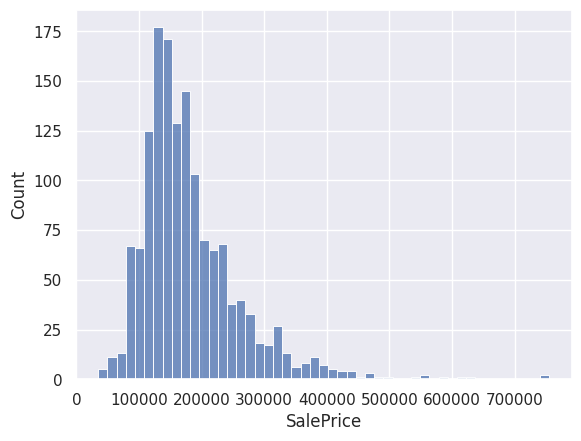

In [ ]:
sns.histplot(train['SalePrice'])

In [ ]:
#skewness and kurtosis
print('skewness:',train['SalePrice'].skew())
print('kurtosis:', train['SalePrice'].kurtosis())

skewness: 1.8828757597682129
kurtosis: 6.536281860064529


In [ ]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [ ]:
print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


# **3. Keep calm and work smart**

*   Correlation matrix (heatmap style).
*   'SalePrice' correlation matrix (zoomed heatmap style).
*   Scatter plots between the most correlated variables (move like Jagger style).

**Correlation matrix (heatmap style)**

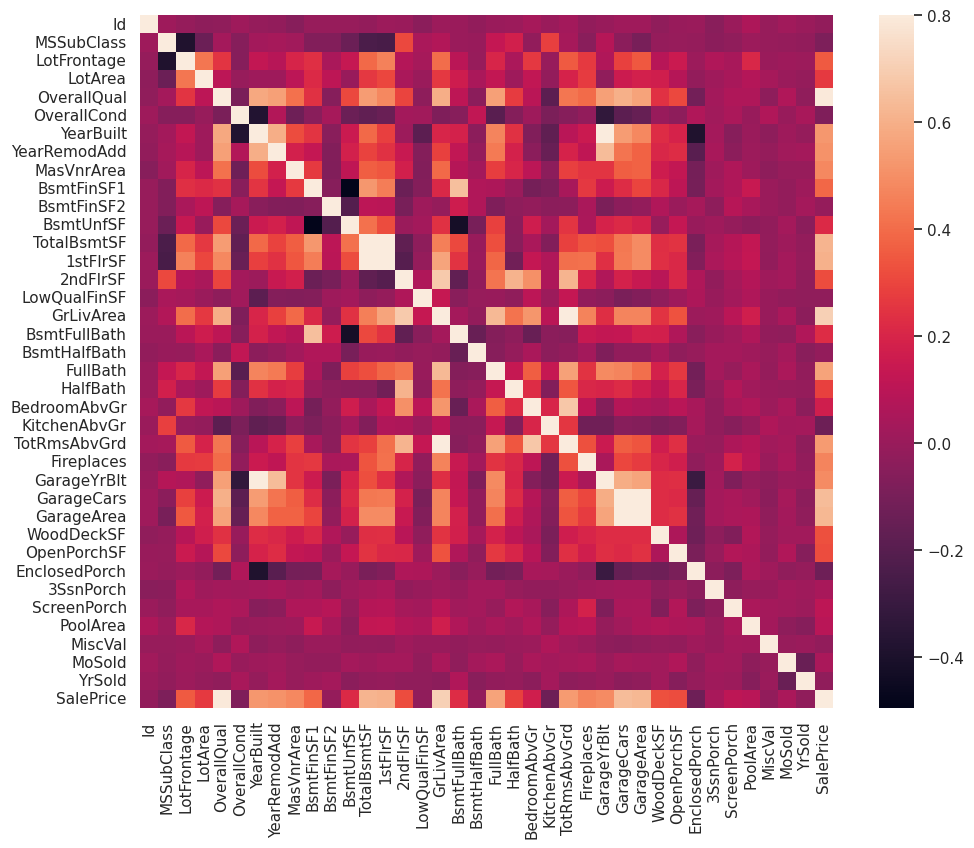

In [ ]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
#figsize=(12,9) >>> (12,9) 是甚麼意思??

**'SalePrice' correlation matrix (zoomed heatmap style)**

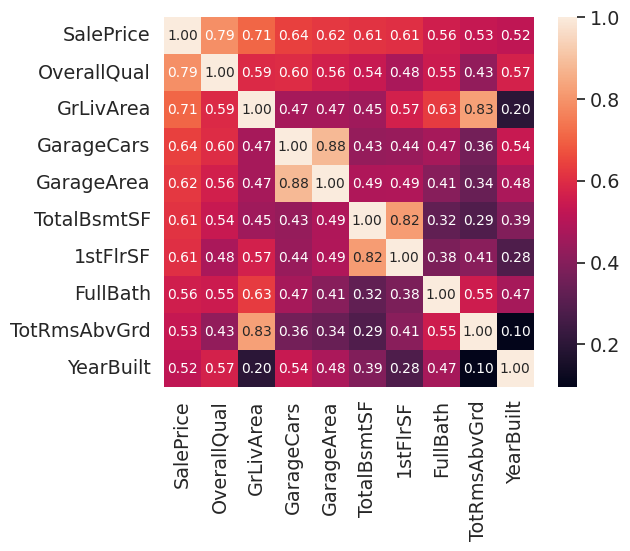

In [ ]:
#saleprice correlation matrix  ### k值怎麼選
k = 10 #number of variables for heatmap
cols= corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm= np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm,cbar=True,annot=True,square=True, fmt='.2f',annot_kws={'size':10},yticklabels=cols.values,xticklabels=cols.values)
plt.show()

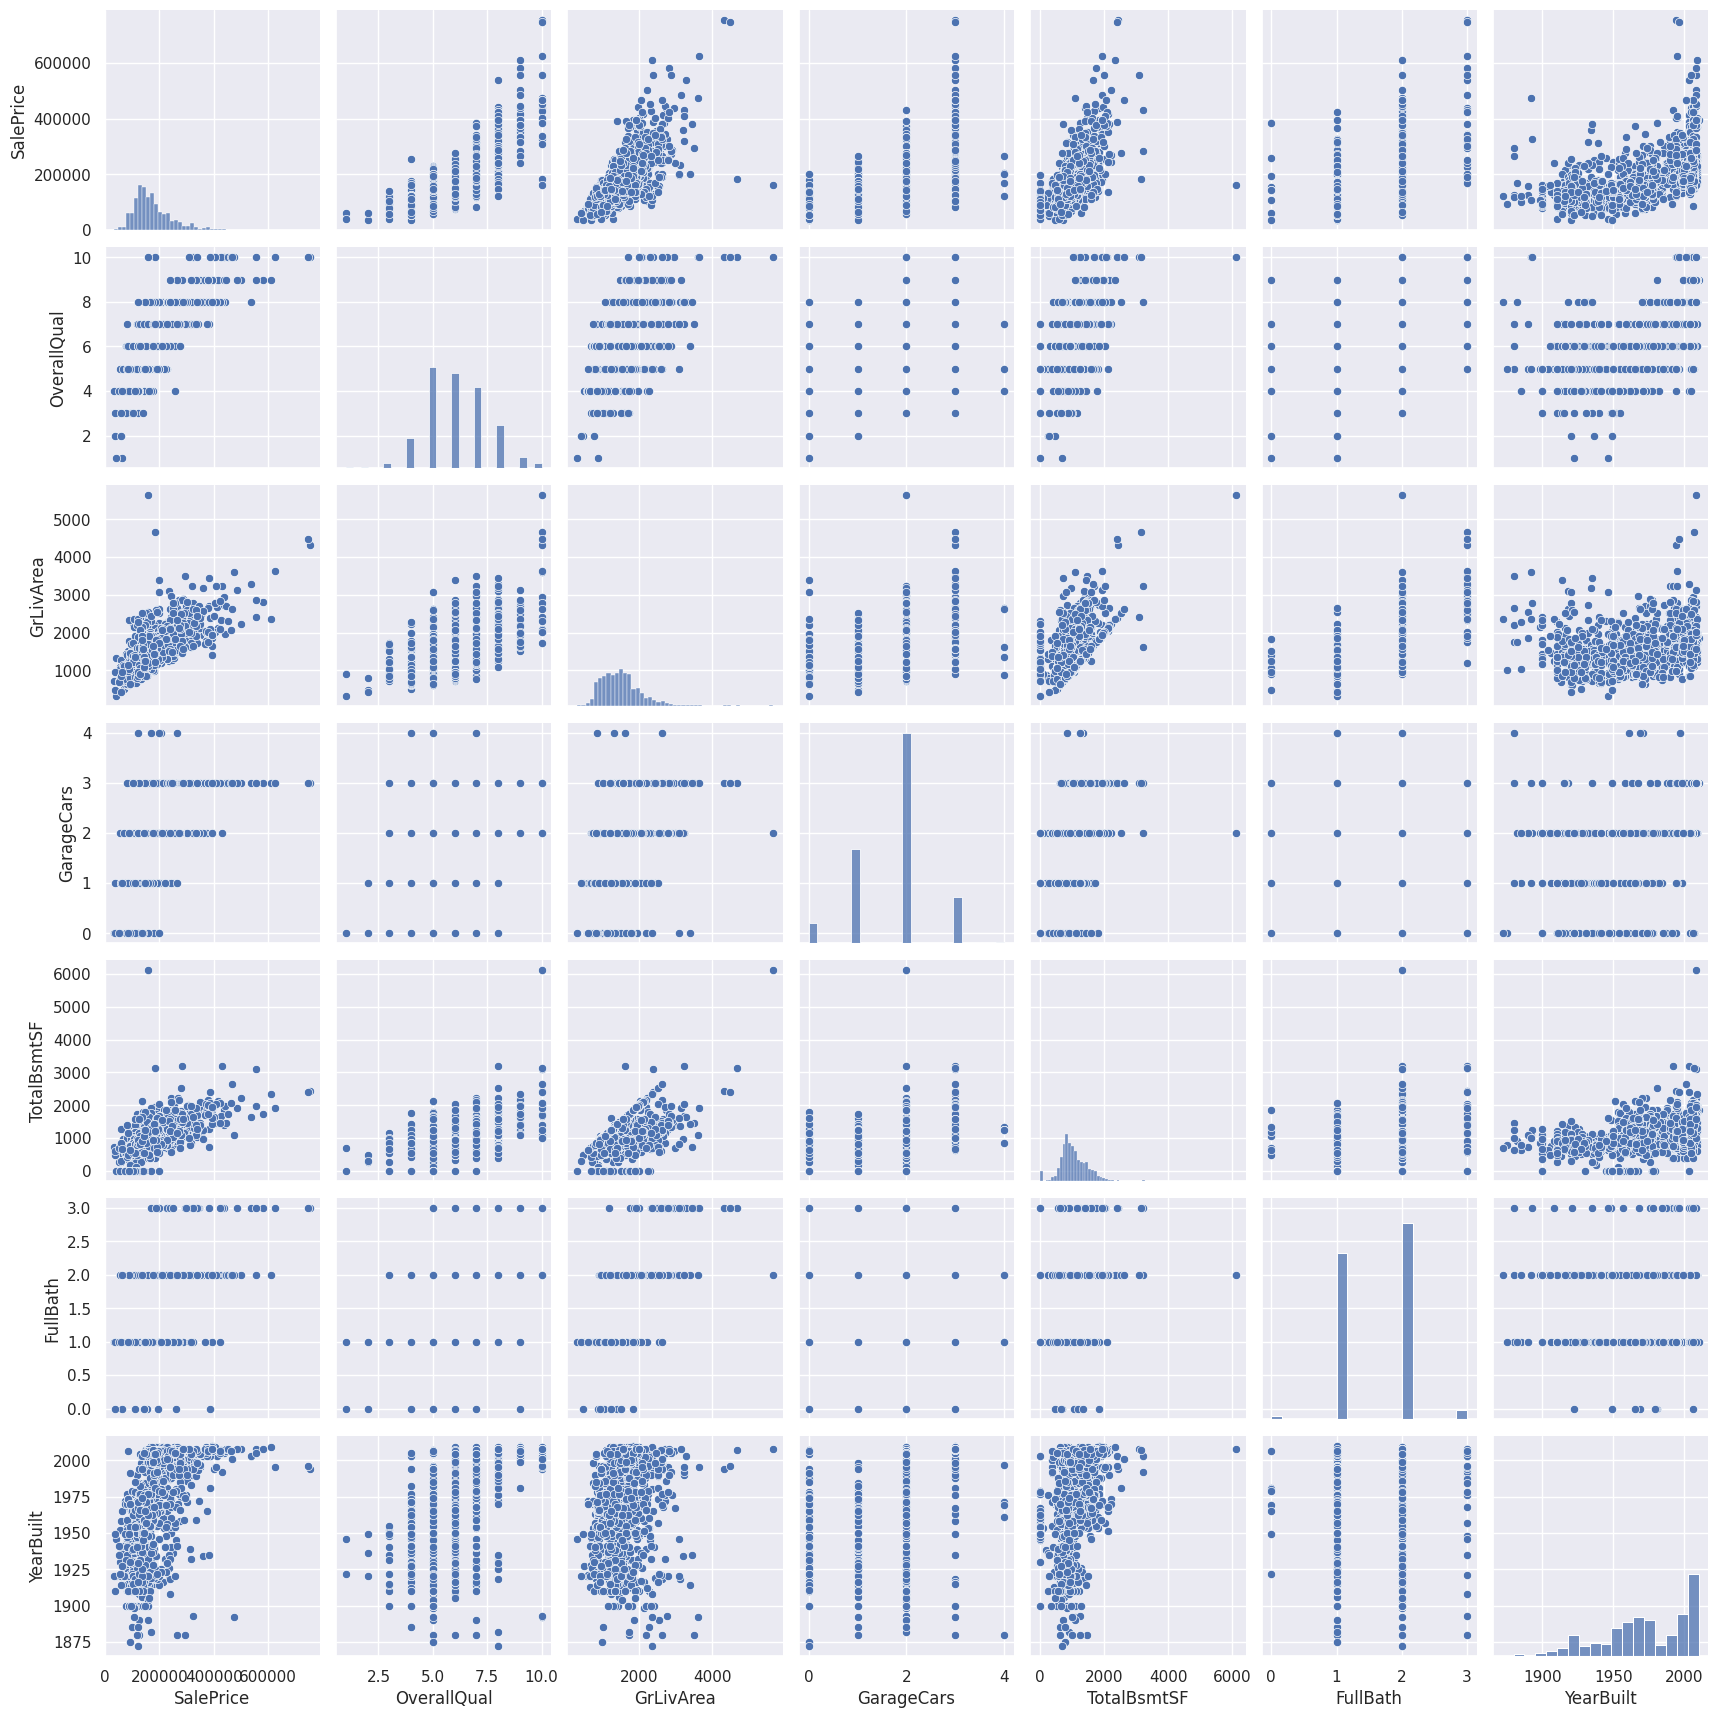

In [ ]:
#scatterplot #類別: 泡泡圖
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

One of the figures we may find interesting is the one between 'TotalBsmtSF' and 'GrLiveArea'. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area (unless you're trying to buy a bunker).

The plot concerning 'SalePrice' and 'YearBuilt' can also make us think. In the bottom of the 'dots cloud', we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (I just wanted to say that prices are increasing faster now).


# **Feature Engineering**:  ### 加入 Predicting house price with linear regression###

1. 一致的特徵轉換： 在特徵工程過程中，你可能會對資料進行一些預處理，例如縮放、編碼、填充缺失值等。這些轉換應當基於整個資料集（訓練和測試），以確保特徵處理的一致性。如果分開處理訓練資料和測試資料，可能會導致轉換不一致，影響模型的性能。


2. 避免資料洩漏： 如果你在分別處理訓練和測試資料時使用了不同的轉換方法，可能會導致資料洩漏（Data Leakage）。資料洩漏是指在模型建立過程中，有關於目標變數的信息在特徵工程中被用到，這可能會導致模型在實際應用時表現不佳。

3. 模型一致性： 當你訓練模型並進行預測時，模型應當能夠處理任何新的、未見過的測試資料。將測試資料與訓練資料一起處理，可以確保模型在實際運行時的一致性。

In [ ]:
# Training and test data sets will be treated jointly in this section. ### WHY????
df = train.append(test)
df.shape

# test.shape

(2920, 81)

# **4. Missing data**

* How prevalent is the missing data?

* Is missing data random or does it have a pattern?

In [ ]:
#missing data ##Comprehensive
# total = train.isnull().sum().sort_values(ascending=False)
# percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
# missing_data = pd.concat([total, percent], axis=1, keys= ['Total','Percent'])
# missing_data.head(20)

## **程式碼說明**
total = df_train.isnull().sum().sort_values(ascending=False): 這一行計算每個變數在資料框 df_train 中的缺失值總數。.isnull() 函數用於檢測缺失值，.sum() 函數計算每個變數中缺失值的總數，sort_values(ascending=False) 函數則按降序排列這些總數，以便後續的呈現。

percent = (df_train.isnull().sum() / df_train.isnull().count()).sort_values(ascending=False): 這一行計算每個變數的缺失值比例。計算方法是將每個變數的缺失值總數除以總觀測數（資料框中的總行數），.isnull().count() 函數用於計算總觀測數，然後使用 .sort_values(ascending=False) 函數按降序排列這些比例。

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']): 這一行使用 pd.concat() 函數將 total 和 percent 兩個序列（Pandas 的 Series）結合成一個資料框 missing_data。axis=1 表示沿著列方向合併，keys=['Total', 'Percent'] 則指定了新資料框的列索引名稱。

missing_data.head(20): 最後一行顯示 missing_data 資料框的前20筆記錄，即顯示了前20個缺失值最多的變數的相關信息，包括總缺失值數和缺失值比例。


In [ ]:
#missing data ###predecting w/ linear reg.

missing_data = df.isna().sum().sort_values(ascending = False)
# percent = (df_combine.isnull().sum()/df_combine.isnull().count()).sort_values(ascending = False)
# missing_data = pd.concat([total, percent], axis=1, keys= ['Total','Percent'])


missing_data.head(20)



PoolQC          2906
MiscFeature     2812
Alley           2738
Fence           2358
Id              1460
FireplaceQu     1380
LotFrontage      518
GarageQual       162
GarageType       162
GarageYrBlt      162
GarageFinish     162
GarageCond       162
BsmtFinType2      76
BsmtExposure      76
BsmtFinType1      74
BsmtQual          74
BsmtCond          74
MasVnrArea        16
MasVnrType        16
Electrical         2
dtype: int64

The missing values in categorical variables can be replaced, in most cases, by a default value indicating the absence of a certain amenity in the house. However this does not apply to the variables  MSZoning
 ,  Utilities
 ,  Functional
 ,  BsmtFullBath
 ,  Exterior1st
 ,  Exterior2nd
 ,  SaleType
 ,  KitchenQual
  and  Electrical
  as, according to the data description, missing values do not indicate that the house is lacking the amenity. Given the small number of cases, the missing values are replaced with the most common category.

  *欄位中的missing value 代表意思不同，分成兩類：是否為　ａｍｅｎｉｔｙ，所以不能把全部缺失值都補０　＃　ＢＵＴ　ＷＨＹ？

In [ ]:
# missing indicates lack of amenity
df['PoolQC'] = df['PoolQC'].fillna('No_pool')
df['MiscFeature'] = df['MiscFeature'].fillna('No_misc')
df['Alley'] = df['Alley'].fillna('No_alley')
df['Fence'] = df['Fence'].fillna('No_fence')
df['FireplaceQu'] = df['FireplaceQu'].fillna('No_fireplace')
df['GarageFinish'] = df['GarageFinish'].fillna('No_garage')
df['GarageQual'] = df['GarageQual'].fillna('No_garage')
df['GarageCond'] = df['GarageCond'].fillna('No_garage')
df['GarageType'] = df['GarageType'].fillna('No_garage')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No_basement')
df['BsmtCond'] = df['BsmtCond'].fillna('No_basement')
df['BsmtQual'] = df['BsmtQual'].fillna('No_basement')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('No_basement')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('No_basement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('No_basement')
df['MasVnrType'] = df['MasVnrType'].fillna('No_masvnr')

# missing does not indicate lack of amenity
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

Regarding the numerical variables, the missing values for  LotFrontage
  can be approximated by the square root of  LotArea
  by assuming the lot shape is a square. It can also be assumed that the garage and the house were built around the same time to impute the missing values in  GarageYrBlt
 . For the remaining variables, the **median value** or the most frequent number (if integer) will be imputed.

 ＊策略基於 **LotArea 和 LotFrontage** 之間的**一定關聯**，因此使用 LotArea 的平方根作為填充值可以在某種程度上保持資料的合理性。


In [ ]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotArea']**0.5)  #LotFrontage can be approximated by the square root of LotArea by assuming the lot shape is a square
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt']) #assumed that the garage and the house were built around the same time to impute the missing values in GarageYrBlt

# median/most frequent value imputation
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])
df['BsmtHalfBath'] = df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])
df['GarageCars'] = df['GarageCars'].fillna(df['GarageCars'].mode()[0])
df['GarageArea'] = df['GarageArea'].fillna(df['GarageArea'].median())
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].median())
df['BsmtUnfSF'] = df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].median())
df['BsmtFinSF2'] = df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].median())
df['BsmtFinSF1'] = df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].median())

missing_data = df.isna().sum().sort_values(ascending = False)
missing_data.head(5)

Id             1460
CentralAir        0
GarageYrBlt       0
GarageType        0
FireplaceQu       0
dtype: int64

**Categorical variables**


Two categorical variables  *MSSubClass*
  and  *MoSold*
  were encoded as numerical variables.
  
  ***They should be encoded as categorical variables since they are not ordinal***.
  #MSSubClass: The building class
  


In [ ]:
df = df.replace({"MSSubClass":{20:"SC20", 30:"SC30", 40:"SC40",
                               45:"SC45", 50:"SC50", 60:"SC60",
                               70:"SC70", 75:"SC75", 80:"SC80",
                               85:"SC85", 90:"SC90", 120:"SC120",
                               150:"SC150", 160:"SC160",
                               180:"SC180", 190:"SC190"},
                 "MoSold":{1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr",
                           5:"May", 6:"Jun", 7:"Jul", 8:"Aug",
                           9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}})

There is **only one** observation 'Po' (poor) in  HeatingQC
 . It can be added to the label 'Fa' (fair). Additionally, the effect of heating quality on the sale price depends on the season. When it is cold, the quality of the heating matters the most! This is to be expected considering that the data set comprises of houses located in Ames, Iowa, where the average temperature in winter is well below freezing. Based on the plot, it is evident that houses with a heating quality condition of "Fa" experienced lower sale **prices during the winter compared to the rest of the year**. To account for this, a **dummy variable named  Winter_poor_heating**
  is created.

In [ ]:
df['HeatingQC'] = df['HeatingQC'].replace('Po', 'Fa')

# Define a function to determine if a month is in winter
def season_winter(row):
  if row['MoSold'] in ['Dec', 'Jan', 'Feb']:
    return 1
  else:
    return 0

# Apply the function to each row and create a new 'Winter' column
df['Winter'] = df.apply(lambda row: season_winter(row), axis = 1).astype('int8')

# Define a function to identify if a sale happened in winter with poor heating quality
def winter_poor_heating_dummy(row):
  if (row['Winter'] == 1) & (row['HeatingQC'] == 'Fa'):
    return 1
  else:
    return 0
# Apply the function to each row and create a new 'Winter_poor_heating' column
df['Winter_poor_heating'] = df.apply(lambda row: winter_poor_heating_dummy(row),
                                     axis = 1).astype('int8')

In these code snippets:

* The `season_winter` function determines whether a given month is during winter.
* The `df.apply()` function applies the season_winter function to each row and creates a new column Winter that indicates whether the sale occurred during winter.
* The `winter_poor_heating_dummy` function checks if a sale happened during winter with poor heating quality.
* The second `df.apply()` function applies the winter_poor_heating_dummy function to each row and creates a new column Winter_poor_heating indicating whether the sale occurred during winter with poor heating quality.

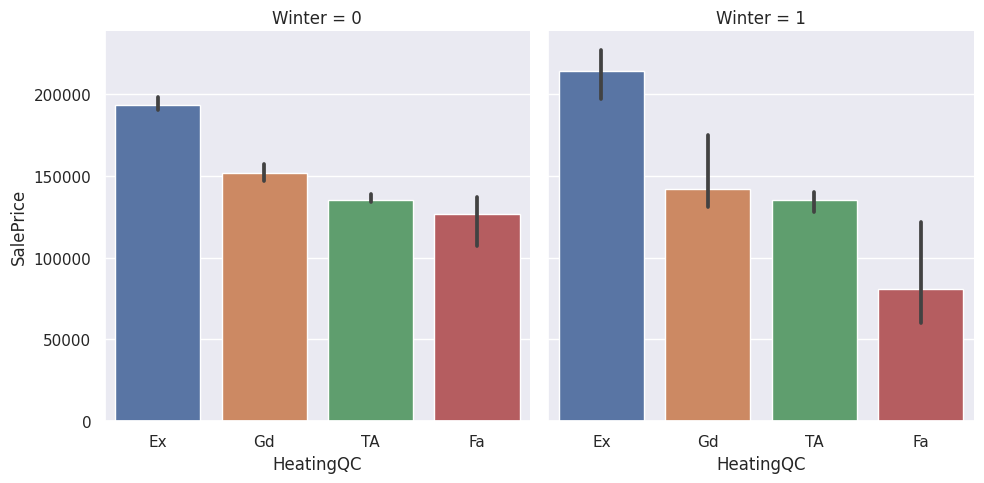

In [ ]:
sns.catplot(df, x = 'HeatingQC', y = 'SalePrice', col = 'Winter', kind = 'bar', estimator = 'median')

Both  OverallQual
  and  OverallCond
  are ordinal variables, which allows us to use an ordinal encoding and treat them as if they were numerical variables. However, their relationship with  SalePrice
  differs. In the case of  OverallQual
 , there is a clear positive relationship, indicating that higher quality houses have higher sale prices. On the other hand, for  OverallCond
 , the relationship is less straightforward. It appears that houses with poor conditions ( OverallQual<5
 ) have lower  SalePrice
  compared to houses with fair or good conditions ( OverallQual≥5
 ), but the exact degree of the condition within each group does not significantly affect the price. This pattern is also observed in the variable  ExterCond
 . To account for these effects, we can use two dummy variables that capture the distinctions in condition: one for houses with poor overall conditions and another for houses with poor external conditions.

<Axes: xlabel='OverallCond', ylabel='SalePrice'>

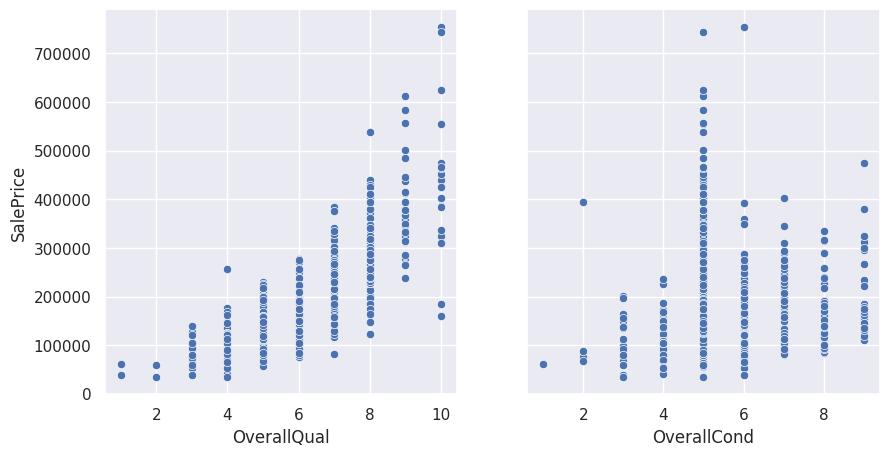

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
sns.scatterplot(df, x='OverallQual', y='SalePrice', ax = axes[0])
sns.scatterplot(df, x='OverallCond', y='SalePrice', ax = axes[1])

In [ ]:
df.groupby('OverallCond')['SalePrice'].agg(['count', 'mean'])

,count,mean
OverallCond,,
1,2,61000.000000
2,10,141986.400000
3,50,101929.400000
4,114,120438.438596
5,1642,203146.914738
6,504,153961.591270
7,410,158145.487805
8,144,155651.736111
9,44,216004.545455


In [ ]:
def dummy_condition(row):
  if row['OverallCond'] < 5:
    return 1
  else:
    return 0

df['Poor_condition'] = df.apply(lambda row: dummy_condition(row),
                                axis = 1).astype('int8')

def dummy_extercondition(row):
  if row['ExterCond']in ['Fa', 'Po']:
    return 1
  else:
    return 0

df['Poor_exter_condition'] = df.apply(lambda row: dummy_extercondition(row),
                                axis = 1).astype('int8')

The ordinal categorical variables  KitchenQual
 ,  HeatingQC
 ,  ExterQual
 ,  ExterCond
 ,  BsmtQual
  and  FireplaceQu
  are encoded as numerical variables.

In [ ]:
def numerical_encoding(row, col_name):
  if row[col_name] == 'Ex':
    return 5
  elif row[col_name] == 'Gd':
    return 4
  elif row[col_name] == 'TA':
    return 3
  elif row[col_name] == 'Fa':
    return 2
  elif row[col_name] == 'Po':
    return 1
  else:
    return 0

df['HeatingQC'] = df.apply(lambda row: numerical_encoding(row, 'HeatingQC'), axis = 1).astype('int8')
df['KitchenQual'] = df.apply(lambda row: numerical_encoding(row, 'KitchenQual'), axis = 1).astype('int8')
df['ExterQual'] = df.apply(lambda row: numerical_encoding(row, 'ExterQual'), axis = 1).astype('int8')
df['ExterCond'] = df.apply(lambda row: numerical_encoding(row, 'ExterCond'), axis = 1).astype('int8')
df['BsmtQual'] = df.apply(lambda row: numerical_encoding(row, 'BsmtQual'), axis = 1).astype('int8')
df['FireplaceQu'] = df.apply(lambda row: numerical_encoding(row, 'FireplaceQu'), axis = 1).astype('int8')

When fitting the model, it becomes problematic to deal with categorical variables that have numerous levels but insufficient observations for certain levels.  MSSubClass
  is one example. Since  HouseStyle
  and  YearBuilt
  contain most of the information in  MSSubClass
 , it can be excluded from our model without losing much information. Another example is  Neighborhood
 . It has 25 levels some of them with very few observations (e.g. Blueste with just 2 observations). One possibility is to group the neighbourhoods by their desirability. This can be done by assuming that houses in desirable locations will be made of better quality material and will be kept in better conditions. Given this assumption, a composite variable ( Location
 ) that describes the desirability of a neighborhood can be created from  OverallQual
 ,  OverallCond
 ,  ExterQual
 ,  ExterCond
 ,  KitchenQual
 .

In [ ]:
# Calculate a new column 'Condition' as the average of multiple quality-related columns
df['Condition'] = (df['OverallQual'] + df['OverallCond'] + df['ExterQual'] + \
                  df['ExterCond'] + df['KitchenQual'])/5

# Group by 'Neighborhood' and calculate the mean of the 'Condition' column, then categorize into 4 bins
# The categories 'bad', 'fair', 'good', and 'excellent' represent different levels of average condition
Location = pd.qcut(df.groupby('Neighborhood')['Condition'].agg('mean'), 4, labels = ['bad', 'fair', 'good', 'excellent'])

# Merge the calculated 'Location' labels based on 'Neighborhood' back into the original DataFrame
df = pd.merge(df, Location.rename('Location'), how = 'left', on = 'Neighborhood')

# Drop the intermediate column 'Condition' that was used for calculation
df = df.drop(['Condition'], axis = 1)

The calculated mean values are then divided into 4 bins using the `pd.qcut()` function, which creates quantiles with labels 'bad', 'fair', 'good', and 'excellent'.

Additionally, several dummies are created. By creating dummies, we are able to capture most of the information contained in the variable while keeping the model simple (including the original variable in the model requires creating one dummy for each level). The following table includes the rationale for each dummy:

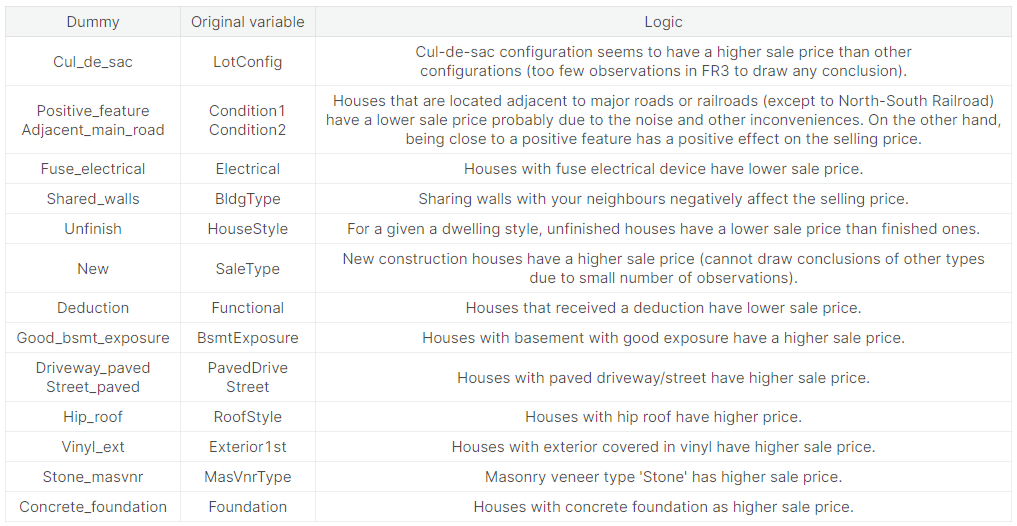


<Axes: xlabel='Foundation', ylabel='SalePrice'>

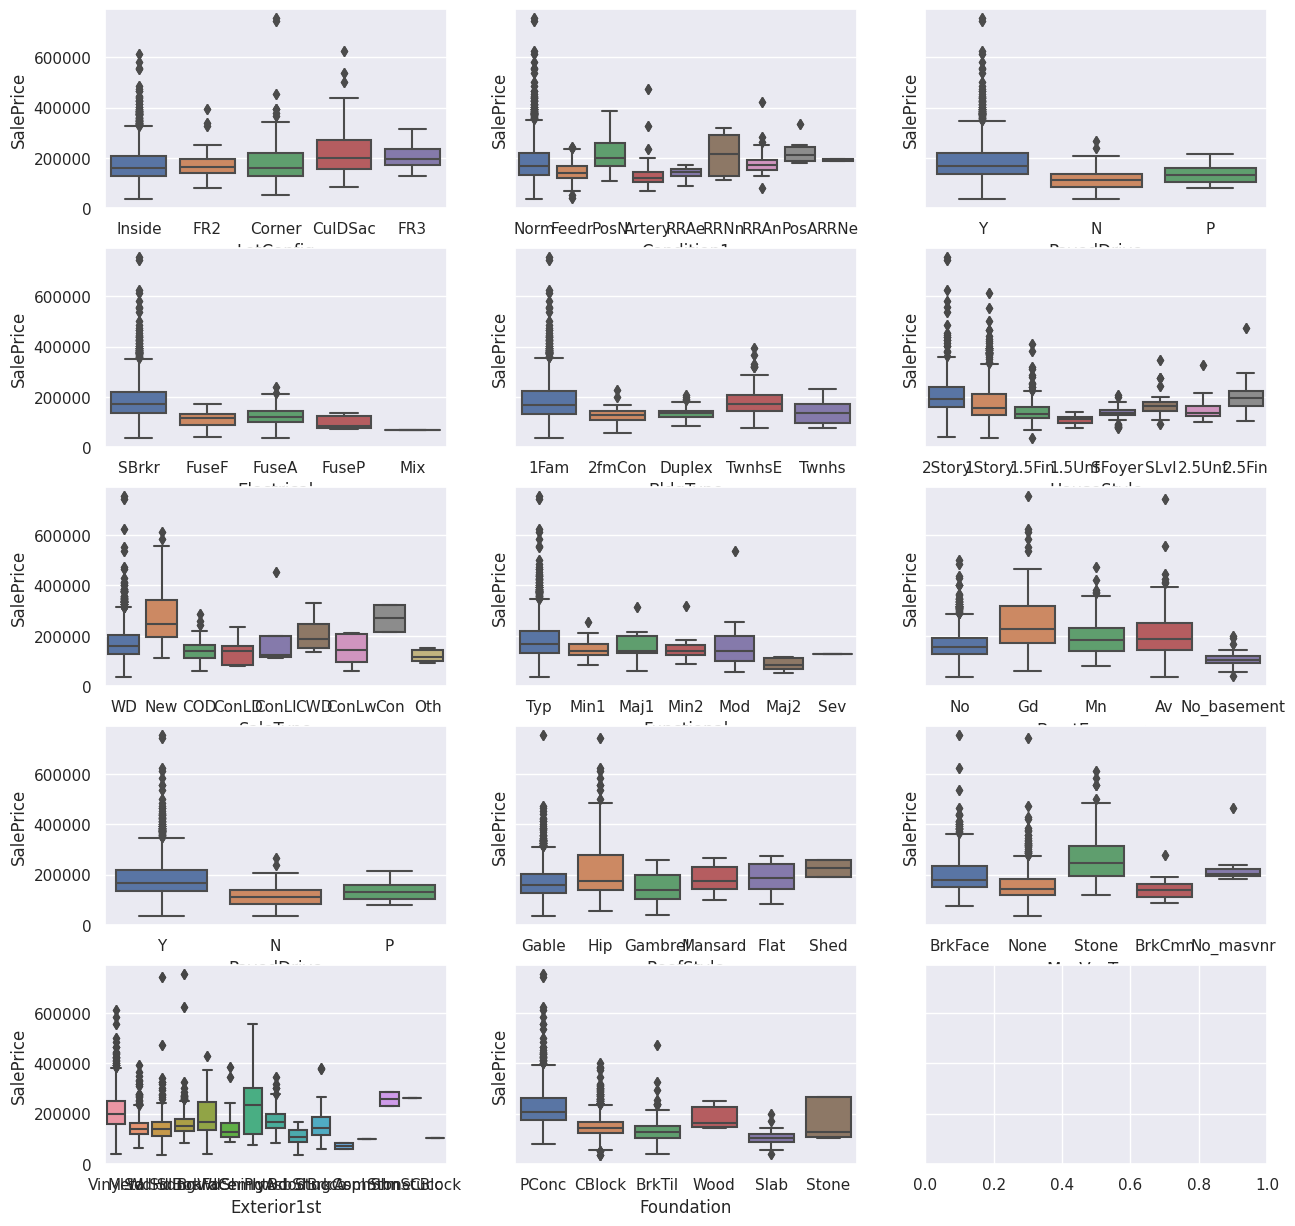

In [ ]:
fig, axes = plt.subplots(5, 3, figsize = (15, 15), sharey = True)
sns.boxplot(df, y = 'SalePrice', x = 'LotConfig', ax = axes[0,0])
sns.boxplot(df, y = 'SalePrice', x = 'Condition1', ax = axes[0,1])
sns.boxplot(df, y = 'SalePrice', x = 'PavedDrive', ax = axes[0,2])
sns.boxplot(df, y = 'SalePrice', x = 'Electrical', ax = axes[1,0])
sns.boxplot(df, y = 'SalePrice', x = 'BldgType', ax = axes[1,1])
sns.boxplot(df, y = 'SalePrice', x = 'HouseStyle', ax = axes[1,2])
sns.boxplot(df, y = 'SalePrice', x = 'SaleType', ax = axes[2,0])
sns.boxplot(df, y = 'SalePrice', x = 'Functional', ax = axes[2,1])
sns.boxplot(df, y = 'SalePrice', x = 'BsmtExposure', ax = axes[2,2])
sns.boxplot(df, y = 'SalePrice', x = 'PavedDrive', ax = axes[3,0])
sns.boxplot(df, y = 'SalePrice', x = 'RoofStyle', ax = axes[3,1])
sns.boxplot(df, y = 'SalePrice', x = 'MasVnrType', ax = axes[3,2])
sns.boxplot(df, y = 'SalePrice', x = 'Exterior1st', ax = axes[4,0])
sns.boxplot(df, y = 'SalePrice', x = 'Foundation', ax = axes[4,1])

In [ ]:
# create Cul_de_sac dummy
def cul_de_sac_dummy(row):
  if row['LotConfig'] == 'CulDSac':
    return 1
  else:
    return 0

df['Cul_de_sac'] = df.apply(lambda row: cul_de_sac_dummy(row), axis = 1).astype('int8')

# create Positive feature dummy
def positive_feature_dummy(row):
  if (row['Condition1'] in ['PosN', 'PosA']) or (row['Condition2'] in ['PosN', 'PosA']):
    return 1
  else:
    return 0

df['Positive_feature'] = df.apply(lambda row: positive_feature_dummy(row), axis = 1).astype('int8')

# create Adjacent_main_road dummy
def adjacent_main_road_dummy(row):
  if (row['Condition1'] in ['Artery', 'Feedr', 'RRAe']) or \
     (row['Condition2'] in ['Artery', 'Feedr', 'RRAe']):
    return 1
  else:
    return 0

df['Adjacent_main_road'] = df.apply(lambda row: adjacent_main_road_dummy(row), axis = 1).astype('int8')

# create Fuse_electrical dummy
def fuse_electrical_dummy(row):
  if (row['Electrical'] in ['FuseA', 'FuseF', 'FuseP', 'Mix']):
    return 1
  else:
    return 0

df['Fuse_electrical'] = df.apply(lambda row: fuse_electrical_dummy(row), axis = 1).astype('int8')

# create Shared_walls dummy
def shared_walls_dummy(row):
  if (row['BldgType'] in ['2FmCon', 'Duplx', 'Twnhs']):
    return 1
  else:
    return 0

df['Shared_walls'] = df.apply(lambda row: shared_walls_dummy(row), axis = 1).astype('int8')

# create Unfinish dummy
def unfinish_dummy(row):
  if (row['HouseStyle'] in ['1.5Unf', '2.5Unf']):
    return 1
  else:
    return 0

df['Unfinish'] = df.apply(lambda row: unfinish_dummy(row), axis = 1).astype('int8')

# create New dummy
def new_dummy(row):
  if (row['SaleType'] == 'New'):
    return 1
  else:
    return 0

df['New'] = df.apply(lambda row: new_dummy(row), axis = 1).astype('int8')

# create Deduction dummy
def deduction_dummy(row):
  if (row['Functional'] == 'Typ'):
    return 0
  else:
    return 1

df['Deduction'] = df.apply(lambda row: deduction_dummy(row), axis = 1).astype('int8')

# create Good_basement_exposure dummy
def basement_exposure_dummy(row):
  if (row['BsmtExposure'] == 'Gd'):
    return 1
  else:
    return 0

df['Good_bsmt_exposure'] = df.apply(lambda row: basement_exposure_dummy(row),
                                        axis = 1).astype('int8')

# create Driveway_paved dummy
def driveway_paved_dummy(row):
  if (row['PavedDrive'] == 'Y'):
    return 1
  else:
    return 0

df['Driveway_paved'] = df.apply(lambda row: driveway_paved_dummy(row),
                                        axis = 1).astype('int8')

# create Street_paved dummy
def street_dummy(row):
  if (row['Street'] == 'Pave'):
    return 1
  else:
    return 0

df['Street_paved'] = df.apply(lambda row: street_dummy(row), axis = 1).astype('int8')

# create Hip_roof dummy
def hiproof_dummy(row):
  if row['RoofStyle'] == 'Hip':
    return 1
  else:
    return 0

df['Hip_roof'] = df.apply(lambda row: hiproof_dummy(row), axis = 1).astype('int8')

# create Vinyl_ext dummy
def vinyl_dummy(row):
  if row['Exterior1st'] == 'VinylSd':
    return 1
  else:
    return 0

df['Vinyl_ext'] = df.apply(lambda row: vinyl_dummy(row), axis = 1).astype('int8')

# create Stone_masvnr dummy
def stone_dummy(row):
  if row['MasVnrType'] == 'Stone':
    return 1
  else:
    return 0

df['Stone_masvnr'] = df.apply(lambda row: stone_dummy(row), axis = 1).astype('int8')

# create Concrete_foundation dummy
def concrete_dummy(row):
  if row['Foundation'] == 'PConc':
    return 1
  else:
    return 0

df['Concrete_foundation'] = df.apply(lambda row: concrete_dummy(row), axis = 1).astype('int8')

# encode CentralAir as numerical
def air_numerical(row):
  if (row['CentralAir'] == 'Y'):
    return 1
  else:
    return 0

df['CentralAir'] = df.apply(lambda row: air_numerical(row), axis = 1).astype('int8')

 **Numerical variables**


The 2000's house price bubble peaked around 2006-2007 while prices started to decline following the outburst of the crisis in 2008. Our data shows that houses with YrSold<2008
 have a higher SalePrice
 than houses with YrSold≥2008
. A dummy variable can be created to capture this.

In [ ]:
train.groupby('YrSold')['SalePrice'].mean()

YrSold
2006    182549.458599
2007    186063.151976
2008    177360.838816
2009    179432.103550
2010    177393.674286
Name: SalePrice, dtype: float64

In [ ]:
def one_hot_year(row):
  if row['YrSold'] >= 2008:
    return 1
  else:
    return 0

df['GFC'] = df.apply(lambda row: one_hot_year(row), axis = 1).astype('int8')

In [ ]:
# df.to_csv('processed_data.csv', index=False)

A variable called  Age
  that describes the age of the house at the moment of sale can be created as  Age=YrSold−YearBuilt
 . As expected, older houses tend to have a lower sale price than newer ones. Moreover, whether the house has been renovated or not appears to also have an effect on  SalePrice
  with renovated houses showing a higher sale price than non-renovated ones for a given age. The dummy variable  Remodel
  is created to capture the interaction effect.

<Axes: xlabel='Age', ylabel='SalePrice'>

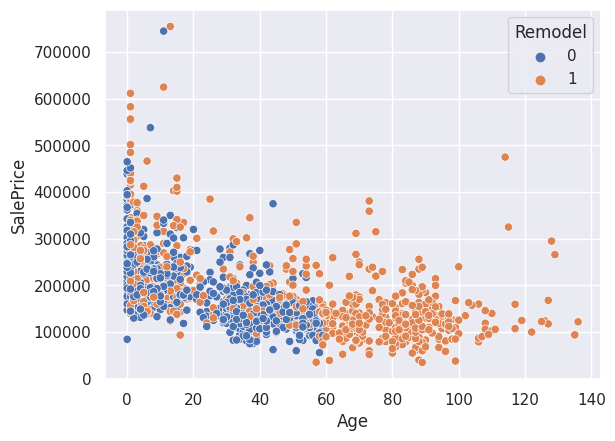

In [ ]:
df['Age'] = df['YrSold'] - df['YearBuilt']

def label_remodel (row):
  if row['YearBuilt'] < row['YearRemodAdd'] :
    return 1
  else:
    return 0

df['Remodel'] = df.apply(lambda row: label_remodel(row), axis=1).astype('int8')

sns.scatterplot(df, x='Age', y='SalePrice', hue='Remodel')

The total area (above grade) of the house is given by  GrLivArea
 . Whether the area comes from the 1st or 2nd floor probably does not have an effect on the sale price. Still, we can create a dummy to describe whether the house has 2nd floor or not. This dummy seems a good candidate for an interaction effect with  GrLivArea
 . Additionally, the dummy  Bsmt
  is created to reflect whether the house has basement or not.
  

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

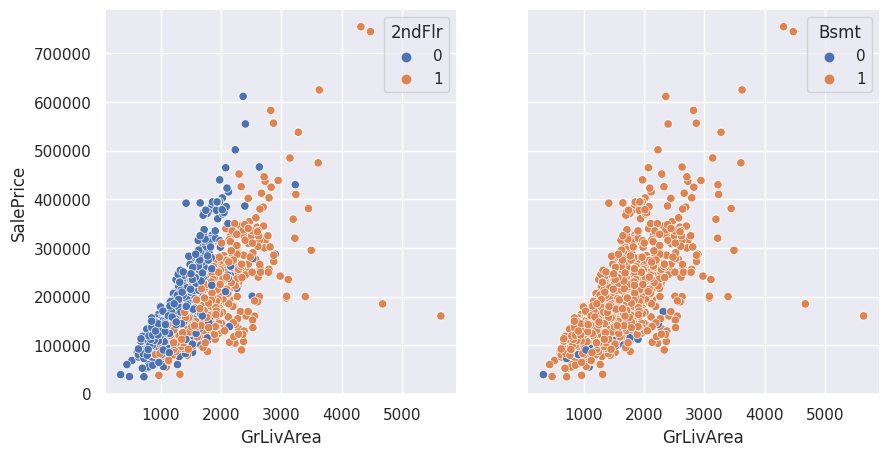

In [ ]:
# Create a new column '2ndFlr' based on whether '2ndFlrSF' is 0 or not
df['2ndFlr'] = pd.cut(df['2ndFlrSF'], bins = [-float('inf'), 0, float('inf')],
                      labels = [0, 1]).astype('int8')

# Create a new column 'Bsmt' based on whether 'TotalBsmtSF' is 0 or not
df['Bsmt'] = pd.cut(df['TotalBsmtSF'], bins = [-float('inf'), 0, float('inf')],
                                  labels = [0, 1]).astype('int8')
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)

# Create a scatterplot in the first subplot with 'GrLivArea' on the x-axis, 'SalePrice' on the y-axis,
# and different colors based on the '2ndFlr' column
sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='2ndFlr', ax = axes[0])

# Create a scatterplot in the second subplot with 'GrLivArea' on the x-axis, 'SalePrice' on the y-axis,
# and different colors based on the 'Bsmt' column
sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='Bsmt', ax = axes[1])

<Axes: xlabel='Pool', ylabel='SalePrice'>

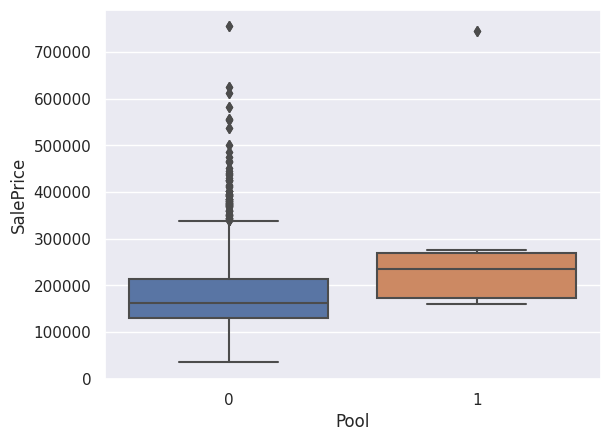

In [ ]:
df['Pool'] = pd.cut(df['PoolArea'], bins = [-float('inf'), 0, float('inf')],
                                  labels = [0, 1]).astype('int8')
sns.boxplot(df, x = 'Pool', y = 'SalePrice')

In [ ]:
# brings 'SalePrice' to the latest column position
columns_order = [col for col in df.columns if col != 'SalePrice'] + ['SalePrice']
df = df[columns_order]

# **Feature selection**

To mitigate multicollinearity, highly correlated groups of variables are pruned, retaining only one representative variable from each group.

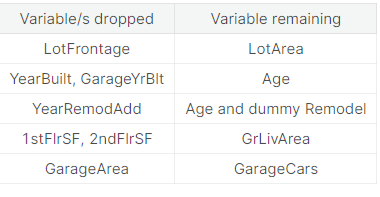

<Axes: >

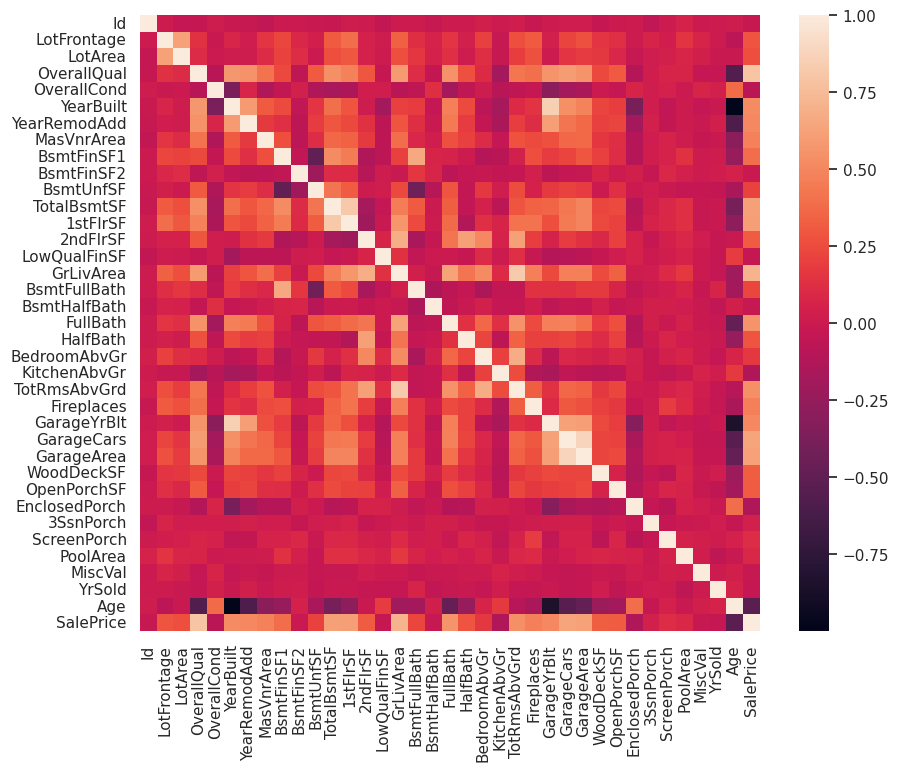

In [ ]:
correlation_matrix = df.select_dtypes(exclude = 'int8').corr()

plt.subplots(figsize = (10, 8))
sns.heatmap(correlation_matrix, vmax = 1)

Additionally, the following variables will not be considered for the modelling part for the reasons specified in the table:

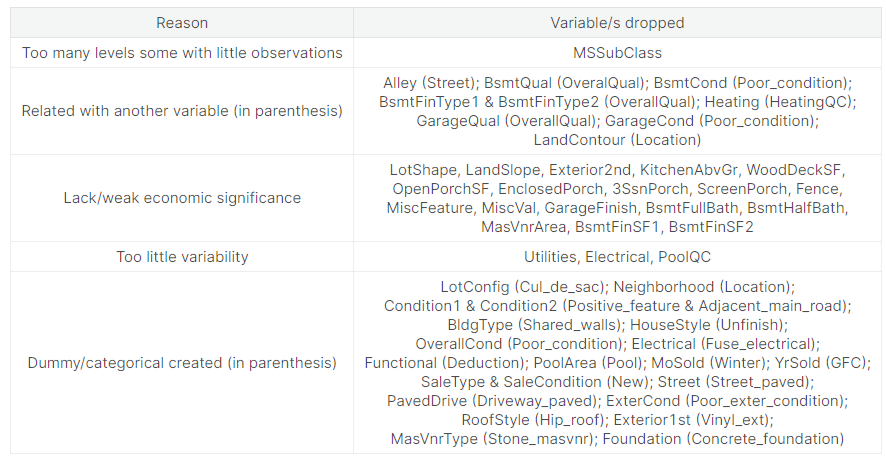

Keep only the variables that will be used in the analysis. Quadratic terms for  LotArea
 ,  Age
  and  GrLivArea
  are generated since from the scatterplots the relationship with  SalePrice
  seem non-linear.

In [ ]:
variables = ['SalePrice', 'Id', 'HeatingQC', 'OverallQual', 'KitchenQual',
             'ExterQual', 'BsmtQual', 'Age', 'GrLivArea', 'BedroomAbvGr',
             'TotalBsmtSF', 'FireplaceQu', 'TotRmsAbvGrd', 'FullBath', 'HalfBath',
             'GarageCars', 'LotArea', 'Winter_poor_heating', 'Poor_condition',
             'Poor_exter_condition','Cul_de_sac',
             'Positive_feature', 'Adjacent_main_road', 'Fuse_electrical',
             'Shared_walls', 'Unfinish', 'New', 'Deduction', 'Good_bsmt_exposure',
             'Driveway_paved', 'Street_paved', 'Hip_roof', 'Vinyl_ext',
             'Stone_masvnr', 'Concrete_foundation', 'CentralAir', 'GFC', 'Remodel',
             '2ndFlr', 'Bsmt', 'Pool', 'Fireplaces', 'MSZoning', 'GarageType']

df = df[variables]

df['LotArea_2'] = df['LotArea']**2
df['Age_2'] = df['Age']**2
df['GrLivArea_2'] = df['GrLivArea']**2

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

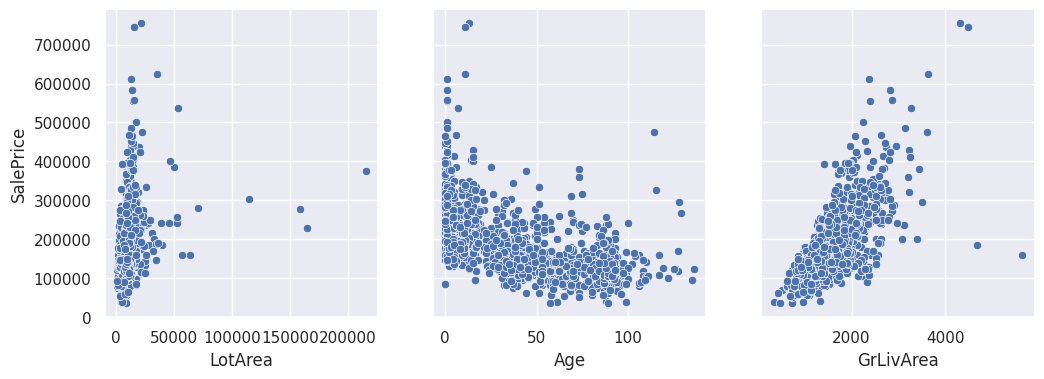

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (12, 4), sharey = True)
sns.scatterplot(df, y = 'SalePrice', x = 'LotArea', ax = axes[0])
sns.scatterplot(df, y = 'SalePrice', x = 'Age', ax = axes[1])
sns.scatterplot(df, y = 'SalePrice', x = 'GrLivArea', ax = axes[2])

Get dummies from categorical variables

In [ ]:
df = pd.get_dummies(df)
df.columns

Index(['SalePrice', 'Id', 'HeatingQC', 'OverallQual', 'KitchenQual',
       'ExterQual', 'BsmtQual', 'Age', 'GrLivArea', 'BedroomAbvGr',
       'TotalBsmtSF', 'FireplaceQu', 'TotRmsAbvGrd', 'FullBath', 'HalfBath',
       'GarageCars', 'LotArea', 'Winter_poor_heating', 'Poor_condition',
       'Poor_exter_condition', 'Cul_de_sac', 'Positive_feature',
       'Adjacent_main_road', 'Fuse_electrical', 'Shared_walls', 'Unfinish',
       'New', 'Deduction', 'Good_bsmt_exposure', 'Driveway_paved',
       'Street_paved', 'Hip_roof', 'Vinyl_ext', 'Stone_masvnr',
       'Concrete_foundation', 'CentralAir', 'GFC', 'Remodel', '2ndFlr', 'Bsmt',
       'Pool', 'Fireplaces', 'LotArea_2', 'Age_2', 'GrLivArea_2',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM', 'GarageType_2Types', 'GarageType_Attchd',
       'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort',
       'GarageType_Detchd', 'GarageType_No_garage'],
      dtype='object')

To avoid perfect multicollinearity, drop  MSZoning_RL
 ,  Location_bad
  and  GarageType_No_garage
 . Also, generate interaction terms.


In [ ]:
df = df.drop(['MSZoning_RL', 'GarageType_No_garage'], axis = 1)

# interaction terms
df['Age_Remodel'] = df['Remodel']*df['Age']
df['GrLivArea_2ndFlr'] = df['GrLivArea']*df['2ndFlr']
df['GrLivArea_Bsmt'] = df['GrLivArea']*df['Bsmt']

train = df.iloc[0:train.shape[0]]
test = df.iloc[train.shape[0]:]

train.shape

(1460, 58)

# **Regression analysis**
Even after feature selection, it is possible that some of the features chosen are not significant or are correlated with other features in the model. This can lead to multicollinearity, which can degrade the performance of the model. Lasso regression can be used to address this issue by shrinking the coefficients of less important variables towards 0. This can help to improve the model's fit and reduce the impact of multicollinearity.

The training dataset is randomly split into train-validation set and holdout (test) set. Additionally,  SalePrice
  is expressed in logarithms since the model is evaluated on the RMSE between the logarithm of the predicted value and the logarithm of the observed sales price.

In [ ]:
X = train.drop(['SalePrice', 'Id'], axis = 1)
Y = np.log(train['SalePrice'])

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [ ]:
scaler = StandardScaler()
train_valid_X = pd.DataFrame(scaler.fit_transform(train_valid_X),
                             columns = train_valid_X.columns)
test_X = pd.DataFrame(scaler.transform(test_X), columns = test_X.columns)

Five-fold cross validation is used to fine-tune the Lasso regularisation parameter. The similar performance in the train-validation and holdout (test) sets suggest that the model has a good generalisation.

In [ ]:
lr_lasso = Lasso()
param_grid = {
    'alpha': np.logspace(-6, -2, 100)
}

lr_lasso = GridSearchCV(lr_lasso, param_grid, scoring='neg_root_mean_squared_error', cv=5)
lr_lasso.fit(train_valid_X, train_valid_Y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-06, 1.09749877e-06, 1.20450354e-06, 1.32194115e-06,
       1.45082878e-06, 1.59228279e-06, 1.74752840e-06, 1.91791026e-06,
       2.10490414e-06, 2.31012970e-06, 2.53536449e-06, 2.78255940e-06,
       3.05385551e-06, 3.35160265e-06, 3.67837977e-06, 4.03701726e-06,
       4.43062146e-06, 4.86260158e-06, 5.33669923e-06, 5....
       1.17681195e-03, 1.29154967e-03, 1.41747416e-03, 1.55567614e-03,
       1.70735265e-03, 1.87381742e-03, 2.05651231e-03, 2.25701972e-03,
       2.47707636e-03, 2.71858824e-03, 2.98364724e-03, 3.27454916e-03,
       3.59381366e-03, 3.94420606e-03, 4.32876128e-03, 4.75081016e-03,
       5.21400829e-03, 5.72236766e-03, 6.28029144e-03, 6.89261210e-03,
       7.56463328e-03, 8.30217568e-03, 9.11162756e-03, 1.00000000e-02])},
             scoring='neg_root_mean_squared_error')

In [ ]:
print("Best Lasso regularisation parameter value:", lr_lasso.best_estimator_)
print("Training score (RMSE):", - lr_lasso.score(train_valid_X, train_valid_Y))
print("Test score (RMSE):", - lr_lasso.score(test_X, test_Y))

Best Lasso regularisation parameter value: Lasso(alpha=0.0029836472402833404)
Training score (RMSE): 0.12976787917280566
Test score (RMSE): 0.18414685851139503


In [ ]:
lr = LinearRegression(fit_intercept = True)
lr.fit(train_valid_X, train_valid_Y)

LinearRegression()

In [ ]:
print("Training score (coefficient of determination):", lr.score(train_valid_X, train_valid_Y))
print("Training score (RMSE):", mean_squared_error(train_valid_Y, lr.predict(train_valid_X))**0.5)
print("Test score (coefficient of determination):", lr.score(test_X, test_Y))
print("Test score (RMSE):", mean_squared_error(test_Y, lr.predict(test_X))**0.5)

Training score (coefficient of determination): 0.9056476429672904
Training score (RMSE): 0.12342786725417505
Test score (coefficient of determination): 0.8380380547106958
Test score (RMSE): 0.15659186731222138


# **Robustness checks**
The residuals exhibit a left-skewed and leptokurtic distribution. Additionally, both the residuals vs. fitted value plot and the Q-Q plot indicate the existence of outliers. Nevertheless, despite these observations, the overall fit appears reasonably good and demonstrates strong performance.

Text(0.5, 1.0, 'Distribution of residuals - Holdout (test) data')

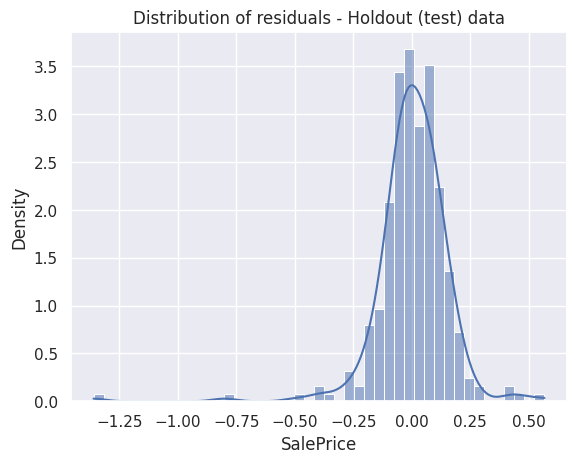

In [ ]:
y_hat = lr.predict(test_X)
test_residuals = test_Y - y_hat

sns.histplot(test_residuals, stat = 'density', kde = True)
plt.title("Distribution of residuals - Holdout (test) data")

Text(0.5, 1.0, 'Residuals (x-axis) vs fitted values (y-axis) - Holdout (test) data')

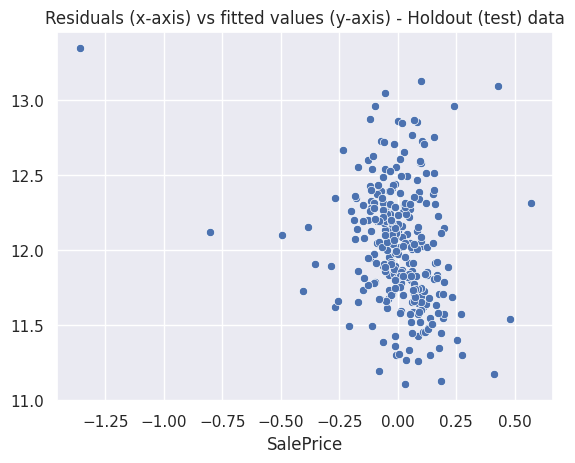

In [ ]:
sns.scatterplot(x = test_residuals, y = y_hat)
plt.title("Residuals (x-axis) vs fitted values (y-axis) - Holdout (test) data") #fitted value程度

Text(0.5, 1.0, 'Quantile-Quantile Plot - Holdout (test) data')

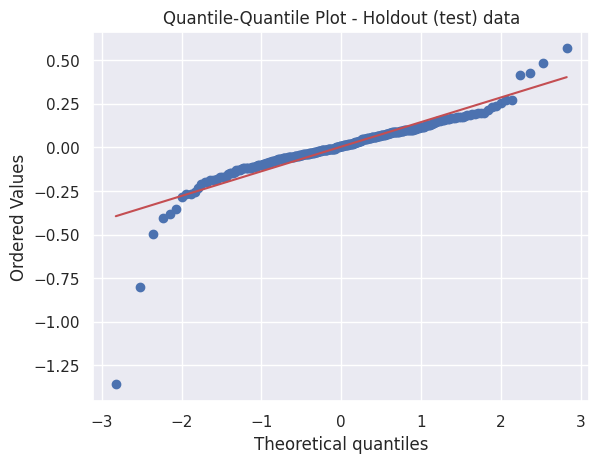

In [ ]:
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot - Holdout (test) data")

Conclusions
The most important variables are GrLivArea
 LotArea
, TotalBsmtSF
, OverallQual
, KitchenQual
, GarageCars
, New
 and Location
. We can claim this because variables have been standardised and thus are measured in the same scale. However, interpretation of coefficients when variables have been standardised is not that straightforward especially for dummy variables.

In [ ]:
estimates = pd.DataFrame({'Regressor': lr.feature_names_in_, 'Coefficient_lr': lr.coef_,
                          'Coefficient_lasso': lr_lasso.best_estimator_.coef_})
estimates.head(60)

,Regressor,Coefficient_lr,Coefficient_lasso
0,HeatingQC,0.020822,0.021137
1,OverallQual,0.078705,0.081272
2,KitchenQual,0.026554,0.030547
3,ExterQual,0.006767,0.006604
4,BsmtQual,0.034024,0.020108
5,Age,0.032027,-0.000000
6,GrLivArea,0.295294,0.138999
7,BedroomAbvGr,-0.014049,-0.000000
8,TotalBsmtSF,0.043661,0.043425
9,FireplaceQu,-0.005163,0.000000


# **Submission**

Train linear regression over entire training data. Then, predict sale price using observations from test set.

In [ ]:
lr.fit(X, Y)

predictions = np.exp(lr.predict(test.drop(['SalePrice', 'Id'], axis = 1)))

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': predictions})

submission.to_csv("submission.csv", index = False)

We'll consider that when more than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed.
(e.g. 'PoolQC', 'MiscFeature', 'Alley', etc.)


'GarageX' variables have the same number of missing data. I bet missing data refers to the same set of observations (although I will not check it; it's just 5% and we should not spend 20 in5 problems).
Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, **I'll delete the mentioned 'GarageX' variables. The same logic applies to 'BsmtX' variables.**



In [ ]:
#dealing with missing data
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

KeyError: ignored

In [ ]:
# num_variables_with_missing = sum(total>0)

# print('num variables with missing = ',num_variables_with_missing)


# **Outliers**

## **單變量分析(univariate analysis)**


In [ ]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

這段程式碼執行了資料標準化操作，然後對「SalePrice」變數進行了一些分析以找出其分佈的外界值（極端值）。以下是程式碼的解釋：

1. `saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:, np.newaxis])`: 這一行程式碼對「SalePrice」變數進行標準化。具體步驟如下：
   - `train['SalePrice']`: 從訓練數據中選擇「SalePrice」變數的數值。
   - `[:, np.newaxis]`: 增加一個新的軸，將一維數組轉換為列向量。
   - `StandardScaler().fit_transform(...)`: 創建一個 `StandardScaler` 物件，用於對數據進行標準化，然後將標準化後的數據賦值給 `saleprice_scaled`。

2. `low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]`: 這一行程式碼找出了「SalePrice」分佈的前10個最小值（外界值 - 低端範圍）。具體步驟如下：
   - `saleprice_scaled[:, 0].argsort()`: 使用 `.argsort()` 函數對標準化後的「SalePrice」列向量進行排序，返回排序後的索引。
   - `[:10]`: 從排序後的索引中選擇前10個索引，即前10個最小值的索引。
   - `saleprice_scaled[...]`: 根據上述索引，從標準化後的「SalePrice」數據中選擇對應的數值。

3. `high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]`: 這一行程式碼找出了「SalePrice」分佈的後10個最大值（外界值 - 高端範圍）。步驟與 `low_range` 的解釋類似。

4. `print('outer range (low) of the distribution:')`: 輸出顯示「SalePrice」分佈的外界值範圍的標題。

5. `print(low_range)`: 輸出顯示低端外界值範圍的標準化數據。

6. `print('\nouter range (high) of the distribution:')`: 輸出顯示「SalePrice」分佈的高端外界值範圍的標題。`\n` 是換行符號，用於在輸出中換行。

7. `print(high_range)`: 輸出顯示高端外界值範圍的標準化數據。

總之，這段程式碼對「SalePrice」變數進行了標準化，然後找出了分佈中的外界值範圍（低端和高端），並輸出這些範圍的標準化數據。這些操作有助於理解「SalePrice」變數的分佈情況，特別是關於極端值的部分。

## **雙變量分析(bivariate analysis)**
雙變量分析(bivariate analysis) 是對這兩組資料之交互關係的描述性統計。 如果對兩組資料分別做統計，例如分別計算其次數分布， 那是做兩次單變量分析(univariate analysis)； 只有企圖探索兩組資料之間的關係時，才會稱為雙變量分析

In [ ]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train['SalePrice'],train[var]],axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
#deleting points
train.sort_values(by= 'GrLivArea', ascending=False)[:2]
#print(x)
train = train.drop(train[train['Id']== 1299].index)
train = train.drop(train[train['Id']== 524].index)


In [ ]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data =pd.concat([train['SalePrice'],train[var]], axis = 1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [ ]:
#deleting points #drop
#train.sort_values(by='TotalBsmtSF', ascending = False) [:2] #332#496
#train=train.drop(train[train['Id']==332].index)
#train=train.drop(train[train['Id']==496].index)


# **5. Getting hard core**

In [ ]:
#hisgram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig =plt.figure()
res=stats.probplot(train['SalePrice'],plot=plt)

Ok, 'SalePrice' is not normal. It shows 'peakedness', positive skewness and does not follow the diagonal line.

非常態分布，左偏

In [ ]:
# applying Iog transformation >> 用log調整  #### 思考:除了log還有其他方法嗎?
train['SalePrice']=np.log(train['SalePrice'])

In [ ]:
#transformed histogram and normal probability plot >> 畫出來
sns.distplot(train['SalePrice'], fit=norm);
fig =plt.figure()
res =stats.probplot(train['SalePrice'],plot=plt)

In [ ]:
## ['GrLivArea']
##histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig =plt.figure()
res=stats.probplot(train['GrLivArea'], plot=plt)

In [ ]:
#data transformation
train['GrLivArea']=np.log(train['GrLivArea'])

In [ ]:
#transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fit =plt.figure()
res =stats.probplot(train['GrLivArea'],plot=plt)

In [ ]:
## Same progress for 'TotalBsmtSF'
# check first!
#histogram and normal probability plot
sns.distplot(train['TotalBsmtSF'],fit=norm)
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot =plt)



+ A significant number of observations with value zero (houses without basement).
* A big problem because the value zero doesn't allow us to do log transformations.

因為這個變數包含0 所以不能做log

we'll do a log transformation to all the **non-zero observations**, ignoring those with value zero.


In [ ]:
#applying log transform
#train['TotalBsmtSF']=np.log(train['TotalBsmtSF'])

In [ ]:
#sns.distplot(train['TotalBsmtSF'], fit=norm, bins=30); ###問! 為什麼不能正規化? ##是因為float64嗎
#fig =plt.figure()
#res= stats.probplot(train['TotalBsmtSF'], plot=plt)

In [ ]:
train['TotalBsmtSF'].info()

In [ ]:
train['GrLivArea'].info()

In [ ]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
###自創欄位，把沒有BST的抓出來，只針對有BST的值做log
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] =0
train.loc[train['TotalBsmtSF']>0,'HasBsmt']=1

In [ ]:
#transform data
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])

df_train：這是一個 DataFrame，代表著資料表。程式碼將在這個 DataFrame 上進行操作。

.loc[]：這是 Pandas 中的索引方式之一，用於按行和列的標籤來選擇資料。這行程式碼使用 .loc[] 進行資料的選擇和修改。

df_train['HasBsmt']==1：這是一個條件，它創建了一個布林 Series，其中每個元素表示對應行的 'HasBsmt' 是否等於 1。假設 'HasBsmt' 是一個欄位，這個條件選擇了 'HasBsmt' 欄位值等於 1 的行。

,'TotalBsmtSF'：這表示在前面條件成立的行中，我們要選擇 'TotalBsmtSF' 欄位。

= np.log(df_train['TotalBsmtSF'])：這部分將所選擇行中的 'TotalBsmtSF' 欄位的值進行對數轉換。np.log() 是 NumPy 函數，用於計算數值的自然對數。

總之，這行程式碼的意思是，對於 DataFrame df_train 中 'HasBsmt' 欄位值等於 1 的行，將這些行中的 'TotalBsmtSF' 欄位的值進行自然對數轉換，然後將轉換後的值寫回到相同的 'TotalBsmtSF' 欄位中。這個操作可能是為了對 'TotalBsmtSF' 欄位進行數值轉換，可能是為了某些數值處理的需求，例如正規化或者使其分佈更為符合某種假設。

In [ ]:
#histogram and normal probability plot
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

`sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)`

 `train[train['TotalBsmtSF']>0]['TotalBsmtSF']` 這段程式碼中，`train['TotalBsmtSF']>0` 回傳的是一個布林 Series，其中每個元素代表對應列中的 'TotalBsmtSF' 是否大於 0。而 `train[train['TotalBsmtSF']>0]` 則是根據這個布林 Series 對原始的 DataFrame 進行篩選，只保留符合條件的列。

接下來，`['TotalBsmtSF']` 這部分並不是用來選擇特定的 ID，而是從符合條件的列中提取 'TotalBsmtSF' 欄的值，最終回傳一個包含了這些值的 Series。

因此，`train[train['TotalBsmtSF']>0]['TotalBsmtSF']` 的解釋是：從原始的 DataFrame 中篩選出 'TotalBsmtSF' 大於 0 條件成立的列，然後從這些列中提取 'TotalBsmtSF' 欄的值，最終得到一個包含符合條件的地下室面積大於 0 的房屋的 'TotalBsmtSF' 數值的 Series。

In [ ]:
#scatter plot # ['GrLivArea']
plt.scatter(train['GrLivArea'],train['SalePrice']);

In [ ]:
#scatter plot # ['TotalBsmtSF']
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);

#df_train[df_train['TotalBsmtSF']>0]['SalePrice']：
#這是 y 軸的數據。與 x 軸類似，這部分選擇了 'TotalBsmtSF' 大於 0 的房屋的 'SalePrice'（售價）數據。

plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')

# **dummy variables**

In [ ]:
#convert categorical variables into dummy
train=pd.get_dummies(train)